In [1]:
import sys
import os

package_path: str = '../..'
if package_path not in sys.path:
    sys.path.append(package_path)

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
from src.analyzer.converter import load_npz
from src.filesystem import get_run_scan_directory
from src.config.config import load_config, ExpConfig


config: ExpConfig = load_config(reload=True)
config.path

ExpPaths(log_dir='./logs', load_dir='E:\\XFEL\\sample_data', analysis_dir='E:\\XFEL\\sample_data', mat_dir='E:\\XFEL\\sample_data\\mat_files', processed_dir='E:\\XFEL\\sample_data\\processed_data', output_dir='E:\\XFEL\\sample_data\\output_data')

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.typing as npt
from roi_rectangle import RoiRectangle

In [5]:
run_n: int = 144
npz_dir: str = get_run_scan_directory(config.path.processed_dir, run_n, 1)
npz_file: str = os.path.join(npz_dir, f"run={run_n:0>4}_scan=0001.npz")

_data: dict[str: npt.NDArray] = load_npz(npz_file)
delays: npt.NDArray = _data["delay"]
images: npt.NDArray = _data["pon"]

print(f'Load "{npz_file}"')
print(f'{delays.shape = }')
print(f'{images.shape = }')

Load "E:\XFEL\sample_data\processed_data\run=144\scan=001\run=0144_scan=0001.npz"
delays.shape = (137,)
images.shape = (137, 514, 1030)


In [6]:
images = np.maximum(0, images)

Text(0.5, 1.0, 'Images Sum')

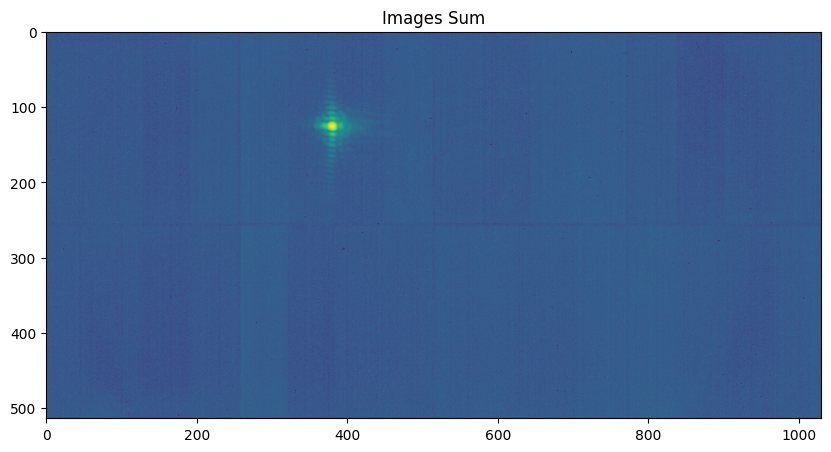

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.imshow(np.log1p(images.sum(0)))
ax.set_title("Images Sum")

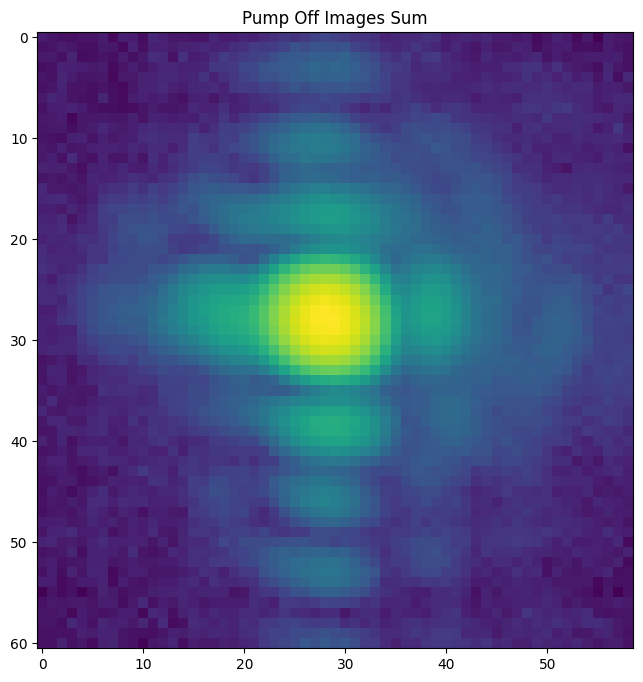

In [ ]:
roi_rect: RoiRectangle = RoiRectangle(x1=352, y1=98, x2=411, y2=159)
roi_images: npt.NDArray = roi_rect.slice(images)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.imshow(np.log1p(roi_images.sum(0)))
ax.set_title("Pump Off Images Sum")

roi_rect
plt.show()

# Tracking

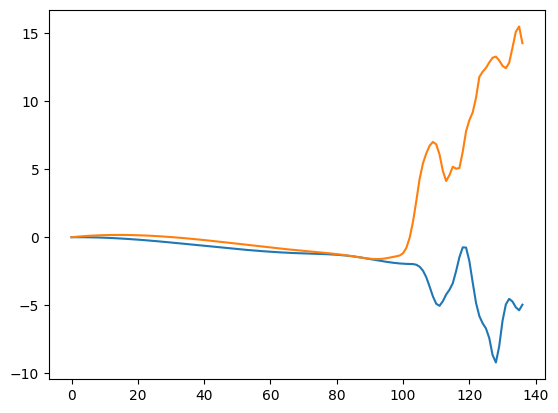

In [94]:
import numpy as np
from scipy.ndimage import center_of_mass, gaussian_filter
from scipy.interpolate import UnivariateSpline

def dynamic_roi_tracking(frames, initial_roi: RoiRectangle, smoothing_factor=2):
    centers = []
    roi = initial_roi
    rois = []
    for frame in frames:
        # Apply Gaussian filter to smooth noise
        smoothed_frame = gaussian_filter(frame, sigma=2)

        # Crop ROI dynamically
        roi_frame = roi.slice(smoothed_frame)

        # Calculate center of mass within ROI
        com = center_of_mass(roi_frame)
        global_com = (roi.y1 + com[0], roi.x1 + com[1])
        centers.append(global_com)

        # Update ROI dynamically
        roi = RoiRectangle(
            y1=max(0, int(global_com[0] - 10)),  # Adjust ROI size
            y2=min(frame.shape[0], int(global_com[0] + 10)),
            x1=max(0, int(global_com[1] - 10)),
            x2=min(frame.shape[1], int(global_com[1] + 10)),
        )
        rois.append(roi)
    # Smooth the trajectory
    centers = np.array(centers)
    smoothed_x = UnivariateSpline(range(len(centers)), centers[:, 0], s=smoothing_factor)
    smoothed_y = UnivariateSpline(range(len(centers)), centers[:, 1], s=smoothing_factor)

    return smoothed_x(range(len(centers))), smoothed_y(range(len(centers))), rois

plt.close()
xs, ys, rois = dynamic_roi_tracking(images, roi_rect)
plt.plot(xs - xs[0])
plt.plot(ys - ys[0])

plt.show()

In [ ]:
from sklearn.mixture import GaussianMixture
from scipy.spatial.distance import cdist

def adaptive_roi_tracking(frames, initial_roi: RoiRectangle, n_clusters=2):
    centers = []
    roi = initial_roi
    for frame in frames:
        # Crop expanded ROI
        expanded_roi = roi.expand(frame.shape, scale=1.5)
        roi_frame = expanded_roi.slice(frame)

        # Cluster peaks within ROI
        y, x = np.nonzero(roi_frame)
        intensities = roi_frame[y, x].reshape(-1, 1)
        gmm = GaussianMixture(n_components=n_clusters)
        gmm.fit(np.column_stack((y, x, intensities)))
        cluster_centers = gmm.means_[:, :2]

        # Match with previous center
        if centers:
            distances = cdist(cluster_centers, [centers[-1]])
            best_idx = np.argmin(distances)
            global_center = (expanded_roi.y1 + cluster_centers[best_idx, 0],
                            expanded_roi.x1 + cluster_centers[best_idx, 1])
        else:
            global_center = (expanded_roi.y1 + cluster_centers[0, 0],
                            expanded_roi.x1 + cluster_centers[0, 1])
        centers.append(global_center)

        # Update ROI
        roi = RoiRectangle(
            y1=max(0, int(global_center[0] - 10)),
            y2=min(frame.shape[0], int(global_center[0] + 10)),
            x1=max(0, int(global_center[1] - 10)),
            x2=min(frame.shape[1], int(global_center[1] + 10)),
        )

    return np.array(centers)


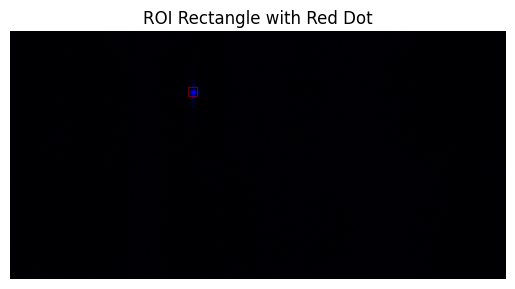

In [100]:
import numpy as np

frames = images.copy()
centers = np.vstack([xs, ys]).T

color = np.array([100, 0, 0])  # 빨간색

color_frames = np.stack([frames] * 3, axis=-1)
color_frames[..., [0, 1]] = (0, 0)
int_centers = np.round(centers).astype(int)

ys = int_centers[:, 0]
xs = int_centers[:, 1]

for i, (y, x, roi) in enumerate(zip(ys, xs, rois)):
    # 무게중심에 빨간 점 찍기
    color_frames[i, y, x, :] = color

    # ROI 네모 테두리 그리기
    color_frames[i, roi.y1:roi.y2, roi.x1, :] = color  # 위쪽 가로선
    color_frames[i, roi.y1:roi.y2, roi.x2-1, :] = color  # 아래쪽 가로선
    color_frames[i, roi.y1, roi.x1:roi.x2, :] = color  # 왼쪽 세로선
    color_frames[i, roi.y2-1, roi.x1:roi.x2, :] = color  # 오른쪽 세로선
    

normalized_frames = np.log1p(color_frames)
normalized_frames = (normalized_frames / normalized_frames.max() * 256).astype(np.uint8)

plt.imshow(normalized_frames[10])
plt.title("ROI Rectangle with Red Dot")
plt.axis('off')  # 축 제거
plt.show()

In [101]:
import tifffile


tifffile.imwrite("all_frames.tif", normalized_frames, imagej=True, photometric='rgb')

In [10]:
from sklearn.cluster import DBSCAN

def dbscan_peak_tracking(frames, eps=5, min_samples=10):
    trajectories = []

    for frame in frames:
        # Threshold to extract peaks
        thresholded = (frame > frame.mean()).astype(np.uint8)
        coordinates = np.column_stack(np.nonzero(thresholded))

        # Apply DBSCAN clustering
        clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(coordinates)
        cluster_centers = np.array([coordinates[clustering.labels_ == label].mean(axis=0) 
                                    for label in set(clustering.labels_) if label != -1])

        trajectories.append(cluster_centers)

    return trajectories

from scipy.signal import cwt, ricker
import numpy as np

def wavelet_peak_tracking(frames, widths=np.arange(1, 10)):
    trajectories = []

    for frame in frames:
        # Apply Wavelet Transform
        transformed = cwt(frame.sum(axis=0), ricker, widths)
        peak_positions = np.argmax(transformed, axis=1)
        trajectories.append(peak_positions)

    # Smooth trajectories
    trajectories = np.array(trajectories)
    smoothed_trajectories = [np.convolve(trajectory, np.ones(5)/5, mode='same') for trajectory in trajectories.T]

    return np.array(smoothed_trajectories).T



C:\Users\ISAAC\AppData\Local\Temp\ipykernel_18540\4045423178.py:28: DeprecationWarning: scipy.signal.cwt is deprecated in SciPy 1.12 and will be removed
in SciPy 1.15. We recommend using PyWavelets instead.

  transformed = cwt(frame.sum(axis=0), ricker, widths)


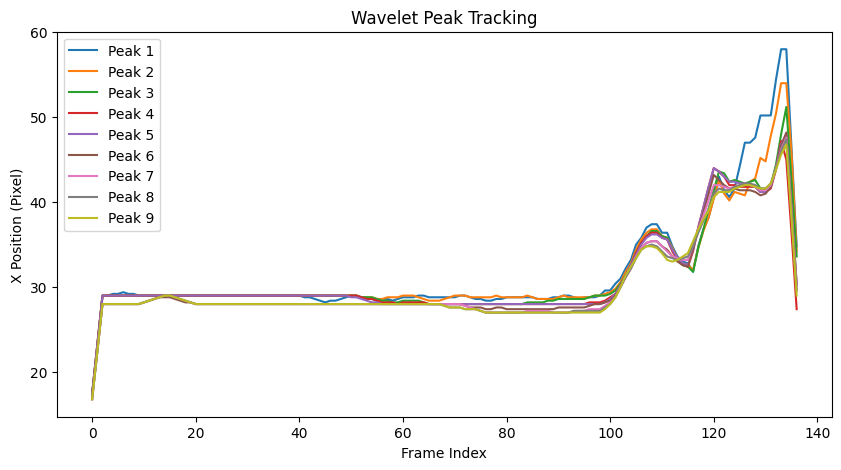

In [ ]:
import matplotlib.pyplot as plt

# 예제 데이터 생성 (랜덤 프레임)
frames = roi_images.copy()

# 1. Wavelet 기반 추적 결과
wavelet_trajectories = wavelet_peak_tracking(frames)

# 3. Wavelet 결과 플롯
plt.figure(figsize=(10, 5))
plt.subplot(1, 1, 1)
for i, trajectory in enumerate(wavelet_trajectories.T):  # 각 peak에 대해 x, y 추적
    plt.plot(range(len(trajectory)), trajectory, label=f"Peak {i + 1}")
plt.title("Wavelet Peak Tracking")
plt.xlabel("Frame Index")
plt.ylabel("X Position (Pixel)")
plt.legend()

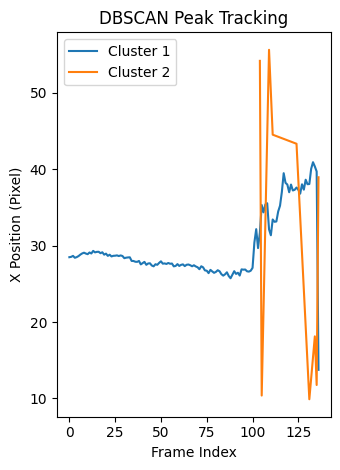

In [25]:
# 2. DBSCAN 기반 추적 결과
dbscan_trajectories = dbscan_peak_tracking(frames)

# 4. DBSCAN 결과 플롯
# plt.subplot(1, 2, 2)
# for i, frame_centers in enumerate(dbscan_trajectories):  # 각 프레임의 클러스터 중심
#     for j, (y, x) in enumerate(frame_centers):  # 클러스터별 x, y 위치
#         plt.scatter(i, x, label=f"Cluster {j + 1}" if i == 0 else "", alpha=0.7)

# 4. DBSCAN 결과 플롯
plt.subplot(1, 2, 2)

# 클러스터별 데이터를 저장
cluster_paths = {}

# 각 프레임에서 클러스터 중심 추적
for i, frame_centers in enumerate(dbscan_trajectories):  # 각 프레임의 클러스터 중심
    for j, (y, x) in enumerate(frame_centers):  # 클러스터별 x, y 위치
        if j not in cluster_paths:
            cluster_paths[j] = {"x": [], "frame": []}
        cluster_paths[j]["x"].append(x)
        cluster_paths[j]["frame"].append(i)

# 클러스터별 궤적 플롯
for cluster_id, path in cluster_paths.items():
    plt.plot(path["frame"], path["x"], label=f"Cluster {cluster_id + 1}")


plt.title("DBSCAN Peak Tracking")
plt.xlabel("Frame Index")
plt.ylabel("X Position (Pixel)")
plt.legend()

plt.tight_layout()
plt.show()

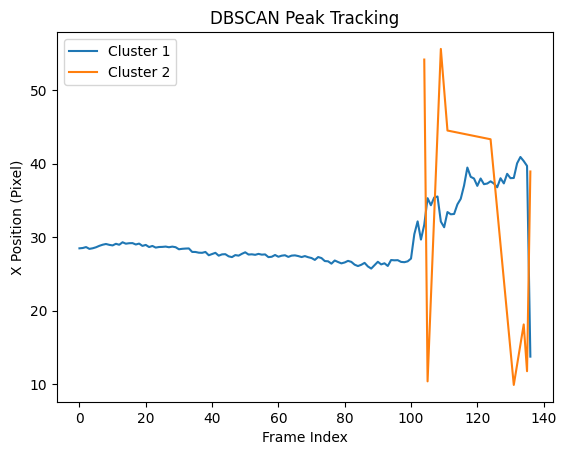

In [20]:
# 클러스터별 데이터를 저장
cluster_paths = {}

# 각 프레임에서 클러스터 중심 추적
for i, frame_centers in enumerate(dbscan_trajectories):  # 각 프레임의 클러스터 중심
    for j, (y, x) in enumerate(frame_centers):  # 클러스터별 x, y 위치
        if j not in cluster_paths:
            cluster_paths[j] = {"x": [], "y": [], "frame": []}
        cluster_paths[j]["x"].append(x)
        cluster_paths[j]["y"].append(y)
        cluster_paths[j]["frame"].append(i)
# 4. DBSCAN 결과 플롯
plt.subplot(1, 1, 1)

# 클러스터별 궤적 플롯
for cluster_id, path in cluster_paths.items():
    plt.plot(path["frame"], path["x"], label=f"Cluster {cluster_id + 1}")

plt.title("DBSCAN Peak Tracking")
plt.xlabel("Frame Index")
plt.ylabel("X Position (Pixel)")
plt.legend()


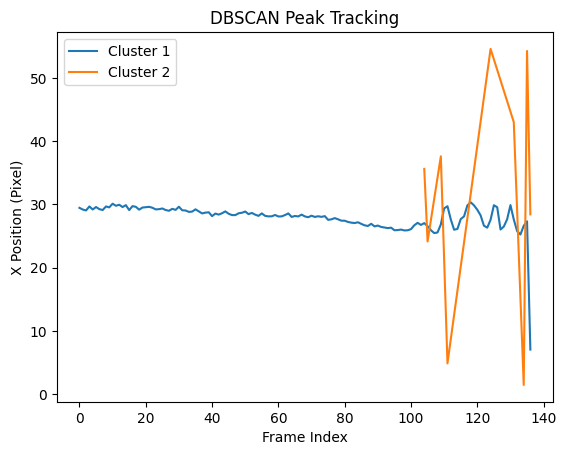

In [21]:
for cluster_id, path in cluster_paths.items():
    plt.plot(path["frame"], path["y"], label=f"Cluster {cluster_id + 1}")

plt.title("DBSCAN Peak Tracking")
plt.xlabel("Frame Index")
plt.ylabel("X Position (Pixel)")
plt.legend()

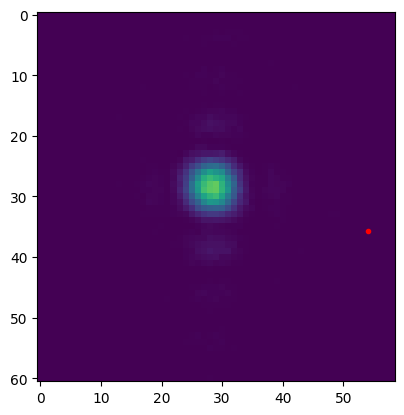

IntSlider(value=0, description='Time:', max=136)

interactive(children=(IntSlider(value=0, description='Time:', max=136), Output()), _dom_classes=('widget-inter…

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, interactive

# 데이터 준비
num_frames = roi_images.shape[0]
image_size = roi_images.shape[1:]
frames = roi_images
centers = np.vstack([path["y"], path["x"]]).T

# 초기 설정
initial_frame = 0

# Matplotlib Figure 생성
fig, ax = plt.subplots()
image_plot = ax.imshow(frames[initial_frame], cmap='viridis', interpolation='nearest')
center_plot, = ax.plot(centers[initial_frame][1], centers[initial_frame][0], 'r.')
image_plot.set_clim(vmin=np.min(frames), vmax=np.max(frames))

# 업데이트 함수
def update(frame_idx):
    image_plot.set_data(frames[frame_idx])
    center_plot.set_data([centers[frame_idx][1]], [centers[frame_idx][0]])
    ax.set_title(f"Frame: {frame_idx}, Center: {centers[frame_idx]}")
    plt.draw()

# 슬라이더 생성 및 출력
slider = IntSlider(min=0, max=num_frames - 1, step=1, value=initial_frame, description='Time:')
interactive_plot = interactive(update, frame_idx=slider)
display(slider, interactive_plot);